In [1]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from helper_functions import Percentile, Normalizer
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Order in which to plot the results
'''spec_parameters = ['Third density coefficient', 'Fourth density coefficient', 'Fifth density coefficient',
                   'Adjacency spectral gap (high)', 'Chung spectrum', 'Out-degree',
                   'Efferent extension rate', 'Normalized Betti coefficient',
                   'Transitive clustering coefficient', 'Relative boundary', 'Euler characteristic']'''
'''
['Relative boundary', 'Fourth density coefficient',
              'Fifth density coefficient', 'Chung spectrum', 'Transitive clustering coefficient',
              'Adjacency spectral gap (low)', 'Afferent extension rate',
              'Normalized Betti coefficient', 'Out-degree', 'Second density coefficient',
              'Euler characteristic']'''
all_parameters = ['Second density coefficient', 
                  'Third density coefficient', 'Fourth density coefficient',
                  'Fifth density coefficient',
                  'Adjacency spectral gap (high)', 'Adjacency spectral gap (low)',
                  'Adjacency spectral radius',
                  'Betti three', 'Betti two', 'Chung spectrum', 
                  'In-degree', 'Out-degree', 
                  'Efferent extension rate', 'Afferent extension rate',
                  'Normalized Betti coefficient', 'Transitive clustering coefficient',
                  'Relative boundary', 'Euler characteristic']
spec_comm_coupling = ['Community coupling', 'Mean tribe community coupling']

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 3")
S = fhlpr("Figure S3")

In [2]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_triads_fn = cfg._cfg['analyzed']['triads']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

tribe_struc_params = data.TopoData(tribe_struc_params_fn)
tribe_triads = data.TopoData(tribe_triads_fn)['overexpression'].map(numpy.array)
tribe_gids = data.TopoData(tribe_gids_fn)['gids']
db = pandas.read_pickle(db_fn)
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']

In [3]:
"""
Some basic analysis that will help in the future.
"""

#  We look up the values of parameters for _all_ tribes from the database so we can compare champions to them
struc_tribe_config = cfg.stage("struc_tribe_analysis")['config']
parameter_specifications = struc_tribe_config['Parameters']
all_struc_params = {}  # values of parameters for all tribes
struc_param_nrmlz_fcn = {}  # functions to normalize values of a parameter between 0 and 1
struc_param_perc_fcn = {}  #  functions to calculate at what percentile a value for a parameter sits
for param_spec in parameter_specifications:
    v = get_column_from_database(db, param_spec['value']['column'],
                                    index=param_spec['value'].get('index', None),
                                    function=param_spec['value'].get("function", None))
    all_struc_params[param_spec['name']] = v
    struc_param_nrmlz_fcn[param_spec['name']] = Normalizer(v)
    struc_param_perc_fcn[param_spec['name']] = Percentile(v)


/home/reimann/venvs/topological_sampling/lib/python3.8/site-packages/toposample/db/lookup_functions.py:40: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(v)


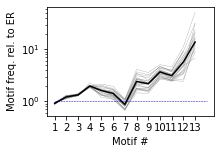

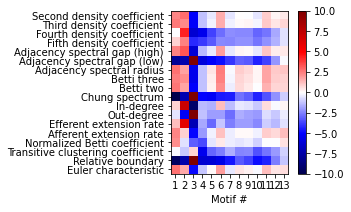

In [4]:
from matplotlib import pyplot as plt

"""
Figure panel: For each champion, its profile of over-and underexpression of triad motifs
"""
epsilon = 1E-05
overexp_raw_volumetric = tribe_triads.filter(sampling="Radius", specifier="175 um")
overexp_raw_parameter = tribe_triads.filter(sampling="Parameter")

#  normalize volumetric counts with respect to an ER control - get mean and std
overexp_rel_volumetric = overexp_raw_volumetric.map(lambda x: (x[0]) / ((x[1]) + epsilon))
overexp_rel_vol_mean = overexp_rel_volumetric.pool(["index"],
                                                   func=lambda x: numpy.nanmean(numpy.vstack(x), axis=0)).get2()
overexp_rel_vol_std = overexp_rel_volumetric.pool(["index"],
                                                  func=lambda x: numpy.nanstd(numpy.vstack(x), axis=0)).get2()
#  normalize counts for tribes with respect to a control that takes tribal sampling into account
overexp_rel_parameter = overexp_raw_parameter.map(lambda x: (x[0]) / ((x[2]) + epsilon))
#  Amount of over / under-expression normalized to the mean and std of the volumetric case
overexp_combined = overexp_rel_parameter.pool(["index"],
                                               func=lambda x: numpy.nanmean(numpy.vstack(x), axis=0))
overexp_combined = overexp_combined.map(lambda x: (x - overexp_rel_vol_mean) / (overexp_rel_vol_std + epsilon))

plot_overexp = numpy.vstack([overexp_combined.get2(specifier=spec)
                             for spec in all_parameters])

fig = plt.figure(figsize=(3,2.0))
ax = fig.gca()
for sample in overexp_rel_volumetric.get():
    ax.plot(numpy.nonzero(sample > 0)[0], sample[sample > 0], color='grey', lw=0.25)
ax.plot(range(len(overexp_rel_vol_mean)), overexp_rel_vol_mean, color='black')
ax.plot([0, 13], [1, 1], ls='--', color='blue', lw=0.5)
ax.set_yscale("log")
ax.set_ylabel("Motif freq. rel. to ER")
ax.set_xticks(numpy.arange(0, 13))
_ = ax.set_xticklabels(numpy.arange(1, 14))
ax.set_xlabel("Motif #")

F.save(fig, fn="Panel-B")

fig = plt.figure(figsize=(3.5, 3.0))
ax = fig.gca()
img = ax.imshow(plot_overexp, cmap='seismic')
img.set_clim([-10, 10])
ax.set_yticks(range(len(all_parameters)))
_ = ax.set_yticklabels(all_parameters)
plt.colorbar(img)
ax.set_xticks(numpy.arange(0, 13))
_ = ax.set_xticklabels(numpy.arange(1, 14))
ax.set_xlabel("Motif #")

F.save(fig, fn="Panel-C")

Third density coefficient is redundant 5 times
	...removing
Adjacency spectral radius is redundant 3 times
	...removing
		 -- although 3 others were equally redundant
Adjacency spectral gap (low) is redundant 2 times
	...removing
		 -- although 5 others were equally redundant
Betti three is redundant 2 times
	...removing
		 -- although 2 others were equally redundant
Second density coefficient is redundant 1 times
	...removing
		 -- although 5 others were equally redundant
Betti two is redundant 1 times
	...removing
		 -- although 3 others were equally redundant
Chung spectrum is redundant 1 times
	...removing
		 -- although 1 others were equally redundant


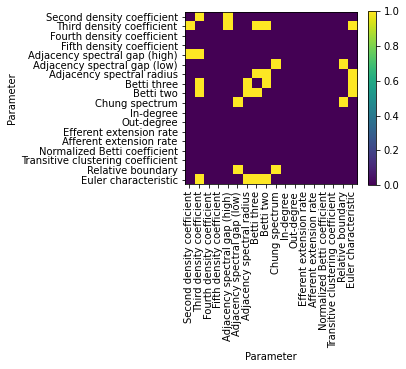

In [5]:
fig = plt.figure(figsize=(3.86, 3.2))
ax = fig.gca()
is_redundant = numpy.abs(numpy.corrcoef(plot_overexp, rowvar=True)) > 0.98
is_redundant[numpy.eye(is_redundant.shape[0]) == 1] = False
img = ax.imshow(is_redundant)
img.set_clim([0, 1])
plt.colorbar(img)
ax.set_xticks(range(len(all_parameters)))
ax.set_xticklabels(all_parameters, rotation='vertical')
ax.set_yticks(range(len(all_parameters)))
ax.set_yticklabels(all_parameters)
ax.set_xlabel("Parameter")
ax.set_ylabel("Parameter")

S.save(fig, fn="Panel-SA")

from helper_functions import find_redundant_entries
_, spec_parameters = find_redundant_entries(numpy.abs(numpy.corrcoef(plot_overexp)), all_parameters, threshold=0.98)
spec_parameters = ['Transitive clustering coefficient', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Adjacency spectral gap (low)', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']

#  We sort the order of parameters by their accuracy in the manifold task
mean_acc = data_acc.filter(sampling="Parameter").pool(["index"],
                                                      func=lambda x: numpy.nanmean(numpy.hstack(x)))
idxx = numpy.argsort([mean_acc.get2(specifier=spec) for spec in spec_parameters])
spec_parameters = [spec_parameters[i] for i in idxx]

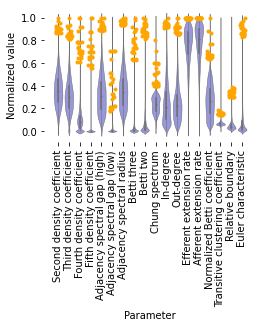

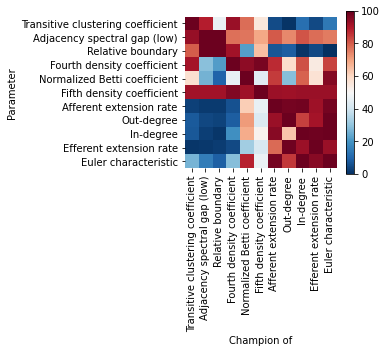

In [6]:
"""
Figure panel: For each parameter its overall (normalized) distribution and the location of its champions
"""
from matplotlib import pyplot as plt
from seaborn import violinplot
#  Get values for each parameter normalized between 0 and 1
plot_struc_values_normalized = dict([(k, struc_param_nrmlz_fcn[k](all_struc_params[k]))
                                    for k in all_parameters])
# Convert into dataframe with two columns: 1st: name of the parameter; 2nd: value of the parameter - for all tribes
plot_dframe = column_names_to_values(pandas.DataFrame(plot_struc_values_normalized),
                                     name_col="Parameter", name_value="Normalized value")

fig = plt.figure(figsize=(3.8, 2.5))
ax = fig.gca()
violinplot(x="Parameter", y="Normalized value", data=plot_dframe,
           ax=ax, scale='width', color=[0.55, 0.55, 0.9], linewidth=0.5)
for plt_x, spec in enumerate(all_parameters):
    raw_y = tribe_struc_params[spec].filter(sampling="Parameter", specifier=spec)
    plt_y = raw_y.map(struc_param_nrmlz_fcn[spec]).get()
    ax.plot(plt_x + 0.5 * (numpy.random.rand(len(plt_y)) - 0.5),
            plt_y, ls='None', marker='.', color='orange')
ax.set_xticks(range(len(all_parameters)))
_ = ax.set_xticklabels(all_parameters, rotation='vertical')
plt.box(False)

F.save(fig, fn="Panel-A")
"""
Figure panel: For each champion the percentile it sits at for each parameter
"""
plot_mat = numpy.zeros((len(spec_parameters), len(spec_parameters)))
for row, spec in enumerate(spec_parameters):
    plot_raw_values = tribe_struc_params[spec].filter(sampling="Parameter").pool(["index"], func=numpy.nanmean)
    plot_perc_values = plot_raw_values.map(struc_param_perc_fcn[spec])
    plot_mat[row, :] = [plot_perc_values.get2(specifier=champ_spec) for champ_spec in spec_parameters]

fig = plt.figure(figsize=(3.4, 3.))
ax = fig.gca()
img = ax.imshow(plot_mat, cmap="RdBu_r")
img.set_clim([0, 100])
plt.colorbar(img)
ax.set_xticks(range(len(spec_parameters)))
ax.set_xticklabels(spec_parameters, rotation='vertical')
ax.set_yticks(range(len(spec_parameters)))
ax.set_yticklabels(spec_parameters)
ax.set_xlabel("Champion of")
ax.set_ylabel("Parameter")
plt.box(False)

S.save(fig, fn="Panel-SB")

In [7]:
print("""NOTE:
The selected non-redundant parameters are:
{0}.

Use the same parameters in the same order in all future notebooks
to generate consistent plots!""".format(spec_parameters))

NOTE:
The selected non-redundant parameters are:
['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic'].

Use the same parameters in the same order in all future notebooks
to generate consistent plots!
